### LSTM - Feature columns: Date Time + Borough || Prediction: Pickup count by Borough

### Utilizes the Categorized pickup labels instead of counts

#### The model is incompatible with the label type as the current Data Transposition preprocessor will sum the discretized labels. Need to approach the problem with a different strategy.

In [95]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# FIX ME: Root dir as argument
root_dir = "../../data/picklerCheckpoints/"
is_compressed = True;
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [96]:
import numpy as np
import pandas as pd
import nbimporter
import geopandas as gpd
import commons.utility.pickle_util as pickle
import Preprocessing.SpatialMapping as sm
import Preprocessing.Discretization as dis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import tensorflow as tf

coord_system = {'init': 'epsg:4326'}

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot

In [98]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
import keras
from keras import layers

In [99]:
data = sm.run(['apr', 'may', 'jun', 'jul', 'aug'])

Data for the month :apr Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-apr14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-apr14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Data for the month :may Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-may14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-may14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Data for the month :jun Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file

In [100]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [101]:
def ljust(lst, n, fillvalue=0):
    return lst + [fillvalue] * (n - len(lst))

In [102]:
def transposeZones(df2, column):
    dftest = df2[['datetime', column, 'pickups']]
    dftest = dftest.sort_values(['datetime', column], ascending=[True, True]).set_index('datetime')
    #dftest.head(len(dftest.zone.unique())-1)
    zone_order = dftest[column].unique()
#     print(zone_order)
    dftest = dftest.groupby('datetime').agg({lambda x: x.tolist()})
    a = dftest.loc[:, ['pickups']].T
    b = dftest.loc[:, [column]].T
    N = len(zone_order)
    M = np.shape(a)[1]
    acc = []
    idx = 0
    for date in a.columns:
        sub_list_start = 0
        sub_list_end = len(a[date])
        row = a[date].values[0]
        acc.append(ljust(row, N))
       # zeros[idx][sub_list_start : sub_list_end+1] = a[date]
        idx = idx + 1
#     print(acc[0])
    zoneDf = pd.DataFrame(acc, columns=zone_order)
    df3 = df2[['datetime', 'dayOfWeek', 'hourOfDay']].drop_duplicates().reset_index()
    return pd.merge(df3, zoneDf, left_index=True, right_index=True).drop(['index', 'datetime'], 1)

In [103]:
df = data.copy()

In [104]:
df2 = df[['datetime', 'borough']]

In [105]:
df2 = dis.encode(df2, ['borough'])

Result Saved in ../data/encodedMappings/borough.p


D:\Academics\MLRepoNew\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "metadata": {},


In [106]:
df2['dayOfWeek'] = pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
df2['hourOfDay'] =  pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
df2['dayOfWeek'] = df2['dayOfWeek'].dt.day_name()
df2['hourOfDay'] = df2['hourOfDay'].dt.hour

<ipython-input-106-9ac9e5788ff7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['dayOfWeek'] = pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
<ipython-input-106-9ac9e5788ff7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['hourOfDay'] =  pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
<ipython-input-106-9ac9e5788ff7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [107]:
week_dict = {
    "Sunday": 1,
    "Monday": 2,
    "Tuesday": 3,
    "Wednesday":4,
    "Thursday":5,
    "Friday": 6,
    "Saturday": 7
}

In [108]:
df2['dayOfWeek'] = df2.dayOfWeek.apply(lambda x: week_dict[x])

<ipython-input-108-35d0f5211b87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['dayOfWeek'] = df2.dayOfWeek.apply(lambda x: week_dict[x])


In [109]:
# data

In [110]:
# cols_to_norm = ['humidity','pressure', 'temperature', 'windDirection', 'windSpeed']
# df2[cols_to_norm] = df2[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [111]:
feature_cols = ['datetime', 'dayOfWeek', 'hourOfDay','borough']
df2 = df2[feature_cols]
N = len(df2['borough'].unique())

In [112]:
df2 = df2.groupby(feature_cols).size().reset_index(name='pickups')

In [113]:
bins = [0, 10, 50, np.inf]
names = ['low', 'med', 'high']

df2['pickups'] = pd.cut(df2['pickups'], bins, labels=names)
df2 = dis.encode(df2, ['pickups'])

Result Saved in ../data/encodedMappings/pickups.p


In [114]:
# pickups = df2['pickups']
# pickups.pop(0)
# pickups.reset_index(inplace=True, drop=True)
# df2.drop(df2.tail(1).index,inplace=True)

In [115]:
# df2['Pickups_t-1h'] = pickups 
# df2['zone'] = df2['borough']

In [116]:
df2 = transposeZones(df2, 'borough')

In [117]:
df2

,dayOfWeek,hourOfDay,1,3,4,2,0,5
0,3,0,2,0,2,0,0,0
1,3,3,2,1,0,2,0,0
2,3,4,0,1,0,2,0,0
3,3,5,1,0,1,0,2,0
4,3,6,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...
3629,1,19,2,0,2,0,0,0
3630,1,20,2,0,2,0,0,1
3631,1,21,2,0,2,0,0,1
3632,1,22,2,0,2,0,0,1


In [118]:
# feature_cols = ['datetime', 'zone', 'dayOfWeek', 'hourOfDay', 'humidity','pressure', 'temperature', 'windDirection', 'windSpeed', 'Pickups_t-1h', 'pickups']
# df2 = df2[feature_cols]

In [119]:
values = df2.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [120]:
reframed = series_to_supervised(scaled, 7, N)

In [121]:
listOfDrops = []
for i in range(7*len(df2.columns),len(reframed.columns)):
    listOfDrops.append(i)

# print("list of drops ", listOfDrops)
reframed.drop(reframed.columns[listOfDrops], axis=1, inplace=True)

In [122]:
values = reframed.values

In [123]:
df2

,dayOfWeek,hourOfDay,1,3,4,2,0,5
0,3,0,2,0,2,0,0,0
1,3,3,2,1,0,2,0,0
2,3,4,0,1,0,2,0,0
3,3,5,1,0,1,0,2,0
4,3,6,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...
3629,1,19,2,0,2,0,0,0
3630,1,20,2,0,2,0,0,1
3631,1,21,2,0,2,0,0,1
3632,1,22,2,0,2,0,0,1


In [124]:
# split into train and test sets
values = reframed.values
n_train_hours = 3000 
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-N], train[:, -N:]
test_X, test_y = test[:, :-N], test[:, -N:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(3000, 1, 50) (3000, 6) (622, 1, 50) (622, 6)


In [125]:
reframed

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var1(t-6),var2(t-6),...,var7(t-2),var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1)
7,0.333333,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.333333,0.130435,...,0.0,0.0,0.333333,0.347826,0.5,0.0,0.5,0.0,0.0,0.0
8,0.333333,0.130435,1.0,0.5,0.0,1.0,0.0,0.0,0.333333,0.173913,...,0.0,0.0,0.333333,0.391304,0.5,0.0,0.5,0.0,0.0,1.0
9,0.333333,0.173913,0.0,0.5,0.0,1.0,0.0,0.0,0.333333,0.217391,...,0.0,1.0,0.333333,0.434783,0.5,0.0,0.5,0.0,0.0,1.0
10,0.333333,0.217391,0.5,0.0,0.5,0.0,1.0,0.0,0.333333,0.260870,...,0.0,1.0,0.333333,0.478261,0.5,0.0,0.0,0.0,0.0,0.0
11,0.333333,0.260870,0.5,0.0,0.5,0.0,0.0,1.0,0.333333,0.304348,...,0.0,0.0,0.333333,0.521739,0.5,0.0,0.5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3624,0.000000,0.304348,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.347826,...,0.0,0.0,0.000000,0.565217,1.0,0.0,1.0,0.0,0.0,0.0
3625,0.000000,0.347826,1.0,0.0,0.5,0.0,0.0,0.0,0.000000,0.391304,...,0.0,0.0,0.000000,0.608696,1.0,0.0,1.0,0.0,0.0,0.0
3626,0.000000,0.391304,1.0,0.0,0.5,0.0,0.0,0.0,0.000000,0.434783,...,0.0,0.0,0.000000,0.652174,1.0,0.0,1.0,0.0,0.0,1.0
3627,0.000000,0.434783,1.0,0.0,0.5,0.0,0.0,0.0,0.000000,0.478261,...,0.0,1.0,0.000000,0.695652,1.0,0.0,1.0,0.0,0.0,0.0


In [126]:
NumOfEpochs = 600
# design network
model = Sequential()
model.add(layers.LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(N))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
start = time.time()
history = model.fit(train_X, train_y, epochs=NumOfEpochs, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
end = time.time()

Epoch 1/600
42/42 - 1s - loss: 0.1620 - accuracy: 0.5530 - val_loss: 0.1376 - val_accuracy: 0.8215
Epoch 2/600
42/42 - 0s - loss: 0.1409 - accuracy: 0.6113 - val_loss: 0.1333 - val_accuracy: 0.8296
Epoch 3/600
42/42 - 0s - loss: 0.1395 - accuracy: 0.6180 - val_loss: 0.1316 - val_accuracy: 0.8296
Epoch 4/600
42/42 - 0s - loss: 0.1372 - accuracy: 0.6213 - val_loss: 0.1287 - val_accuracy: 0.8296
Epoch 5/600
42/42 - 0s - loss: 0.1364 - accuracy: 0.6267 - val_loss: 0.1281 - val_accuracy: 0.8296
Epoch 6/600
42/42 - 0s - loss: 0.1364 - accuracy: 0.6270 - val_loss: 0.1283 - val_accuracy: 0.8280
Epoch 7/600
42/42 - 0s - loss: 0.1347 - accuracy: 0.6267 - val_loss: 0.1258 - val_accuracy: 0.8215
Epoch 8/600
42/42 - 0s - loss: 0.1342 - accuracy: 0.6287 - val_loss: 0.1254 - val_accuracy: 0.8232
Epoch 9/600
42/42 - 0s - loss: 0.1338 - accuracy: 0.6277 - val_loss: 0.1271 - val_accuracy: 0.8199
Epoch 10/600
42/42 - 0s - loss: 0.1334 - accuracy: 0.6280 - val_loss: 0.1241 - val_accuracy: 0.8135
Epoch 11/

42/42 - 0s - loss: 0.1206 - accuracy: 0.6527 - val_loss: 0.1199 - val_accuracy: 0.7814
Epoch 84/600
42/42 - 0s - loss: 0.1204 - accuracy: 0.6513 - val_loss: 0.1196 - val_accuracy: 0.7846
Epoch 85/600
42/42 - 0s - loss: 0.1200 - accuracy: 0.6560 - val_loss: 0.1193 - val_accuracy: 0.7830
Epoch 86/600
42/42 - 0s - loss: 0.1200 - accuracy: 0.6543 - val_loss: 0.1195 - val_accuracy: 0.7765
Epoch 87/600
42/42 - 0s - loss: 0.1198 - accuracy: 0.6523 - val_loss: 0.1194 - val_accuracy: 0.7830
Epoch 88/600
42/42 - 0s - loss: 0.1197 - accuracy: 0.6550 - val_loss: 0.1198 - val_accuracy: 0.7733
Epoch 89/600
42/42 - 0s - loss: 0.1196 - accuracy: 0.6543 - val_loss: 0.1196 - val_accuracy: 0.7797
Epoch 90/600
42/42 - 0s - loss: 0.1197 - accuracy: 0.6547 - val_loss: 0.1199 - val_accuracy: 0.7797
Epoch 91/600
42/42 - 0s - loss: 0.1198 - accuracy: 0.6537 - val_loss: 0.1201 - val_accuracy: 0.7797
Epoch 92/600
42/42 - 0s - loss: 0.1196 - accuracy: 0.6527 - val_loss: 0.1200 - val_accuracy: 0.7830
Epoch 93/600


Epoch 165/600
42/42 - 0s - loss: 0.1118 - accuracy: 0.6677 - val_loss: 0.1259 - val_accuracy: 0.7942
Epoch 166/600
42/42 - 0s - loss: 0.1119 - accuracy: 0.6677 - val_loss: 0.1258 - val_accuracy: 0.7974
Epoch 167/600
42/42 - 0s - loss: 0.1118 - accuracy: 0.6683 - val_loss: 0.1259 - val_accuracy: 0.8006
Epoch 168/600
42/42 - 0s - loss: 0.1119 - accuracy: 0.6680 - val_loss: 0.1258 - val_accuracy: 0.7958
Epoch 169/600
42/42 - 0s - loss: 0.1119 - accuracy: 0.6717 - val_loss: 0.1254 - val_accuracy: 0.7990
Epoch 170/600
42/42 - 0s - loss: 0.1114 - accuracy: 0.6703 - val_loss: 0.1253 - val_accuracy: 0.7926
Epoch 171/600
42/42 - 0s - loss: 0.1113 - accuracy: 0.6690 - val_loss: 0.1252 - val_accuracy: 0.7910
Epoch 172/600
42/42 - 0s - loss: 0.1110 - accuracy: 0.6707 - val_loss: 0.1250 - val_accuracy: 0.7894
Epoch 173/600
42/42 - 0s - loss: 0.1109 - accuracy: 0.6720 - val_loss: 0.1249 - val_accuracy: 0.7910
Epoch 174/600
42/42 - 0s - loss: 0.1109 - accuracy: 0.6717 - val_loss: 0.1257 - val_accurac

42/42 - 0s - loss: 0.1000 - accuracy: 0.6947 - val_loss: 0.1271 - val_accuracy: 0.7862
Epoch 247/600
42/42 - 0s - loss: 0.0998 - accuracy: 0.6923 - val_loss: 0.1274 - val_accuracy: 0.7830
Epoch 248/600
42/42 - 0s - loss: 0.0995 - accuracy: 0.6967 - val_loss: 0.1272 - val_accuracy: 0.7797
Epoch 249/600
42/42 - 0s - loss: 0.0994 - accuracy: 0.6953 - val_loss: 0.1272 - val_accuracy: 0.7862
Epoch 250/600
42/42 - 0s - loss: 0.0993 - accuracy: 0.6917 - val_loss: 0.1272 - val_accuracy: 0.7846
Epoch 251/600
42/42 - 0s - loss: 0.0991 - accuracy: 0.6943 - val_loss: 0.1273 - val_accuracy: 0.7830
Epoch 252/600
42/42 - 0s - loss: 0.0988 - accuracy: 0.6927 - val_loss: 0.1281 - val_accuracy: 0.7846
Epoch 253/600
42/42 - 0s - loss: 0.0987 - accuracy: 0.6960 - val_loss: 0.1277 - val_accuracy: 0.7862
Epoch 254/600
42/42 - 0s - loss: 0.0986 - accuracy: 0.6993 - val_loss: 0.1281 - val_accuracy: 0.7797
Epoch 255/600
42/42 - 0s - loss: 0.0985 - accuracy: 0.7000 - val_loss: 0.1283 - val_accuracy: 0.7749
Epoc

Epoch 328/600
42/42 - 0s - loss: 0.0906 - accuracy: 0.7143 - val_loss: 0.1330 - val_accuracy: 0.7846
Epoch 329/600
42/42 - 0s - loss: 0.0906 - accuracy: 0.7150 - val_loss: 0.1332 - val_accuracy: 0.7846
Epoch 330/600
42/42 - 0s - loss: 0.0911 - accuracy: 0.7170 - val_loss: 0.1326 - val_accuracy: 0.7733
Epoch 331/600
42/42 - 0s - loss: 0.0911 - accuracy: 0.7083 - val_loss: 0.1324 - val_accuracy: 0.7685
Epoch 332/600
42/42 - 0s - loss: 0.0905 - accuracy: 0.7173 - val_loss: 0.1326 - val_accuracy: 0.7669
Epoch 333/600
42/42 - 0s - loss: 0.0909 - accuracy: 0.7150 - val_loss: 0.1335 - val_accuracy: 0.7830
Epoch 334/600
42/42 - 0s - loss: 0.0906 - accuracy: 0.7157 - val_loss: 0.1343 - val_accuracy: 0.7830
Epoch 335/600
42/42 - 0s - loss: 0.0899 - accuracy: 0.7197 - val_loss: 0.1332 - val_accuracy: 0.7685
Epoch 336/600
42/42 - 0s - loss: 0.0895 - accuracy: 0.7183 - val_loss: 0.1329 - val_accuracy: 0.7685
Epoch 337/600
42/42 - 0s - loss: 0.0896 - accuracy: 0.7193 - val_loss: 0.1333 - val_accurac

42/42 - 0s - loss: 0.0841 - accuracy: 0.7230 - val_loss: 0.1372 - val_accuracy: 0.7412
Epoch 410/600
42/42 - 0s - loss: 0.0845 - accuracy: 0.7247 - val_loss: 0.1376 - val_accuracy: 0.7444
Epoch 411/600
42/42 - 0s - loss: 0.0844 - accuracy: 0.7303 - val_loss: 0.1375 - val_accuracy: 0.7379
Epoch 412/600
42/42 - 0s - loss: 0.0839 - accuracy: 0.7327 - val_loss: 0.1375 - val_accuracy: 0.7428
Epoch 413/600
42/42 - 0s - loss: 0.0833 - accuracy: 0.7333 - val_loss: 0.1376 - val_accuracy: 0.7444
Epoch 414/600
42/42 - 0s - loss: 0.0835 - accuracy: 0.7307 - val_loss: 0.1374 - val_accuracy: 0.7476
Epoch 415/600
42/42 - 0s - loss: 0.0828 - accuracy: 0.7283 - val_loss: 0.1368 - val_accuracy: 0.7395
Epoch 416/600
42/42 - 0s - loss: 0.0826 - accuracy: 0.7293 - val_loss: 0.1366 - val_accuracy: 0.7428
Epoch 417/600
42/42 - 0s - loss: 0.0824 - accuracy: 0.7297 - val_loss: 0.1362 - val_accuracy: 0.7428
Epoch 418/600
42/42 - 0s - loss: 0.0824 - accuracy: 0.7313 - val_loss: 0.1363 - val_accuracy: 0.7476
Epoc

Epoch 491/600
42/42 - 0s - loss: 0.0794 - accuracy: 0.7380 - val_loss: 0.1410 - val_accuracy: 0.7492
Epoch 492/600
42/42 - 0s - loss: 0.0794 - accuracy: 0.7330 - val_loss: 0.1406 - val_accuracy: 0.7492
Epoch 493/600
42/42 - 0s - loss: 0.0792 - accuracy: 0.7410 - val_loss: 0.1412 - val_accuracy: 0.7508
Epoch 494/600
42/42 - 0s - loss: 0.0793 - accuracy: 0.7323 - val_loss: 0.1419 - val_accuracy: 0.7701
Epoch 495/600
42/42 - 0s - loss: 0.0799 - accuracy: 0.7287 - val_loss: 0.1419 - val_accuracy: 0.7814
Epoch 496/600
42/42 - 0s - loss: 0.0798 - accuracy: 0.7330 - val_loss: 0.1413 - val_accuracy: 0.7781
Epoch 497/600
42/42 - 0s - loss: 0.0800 - accuracy: 0.7343 - val_loss: 0.1413 - val_accuracy: 0.7846
Epoch 498/600
42/42 - 0s - loss: 0.0801 - accuracy: 0.7293 - val_loss: 0.1416 - val_accuracy: 0.7894
Epoch 499/600
42/42 - 0s - loss: 0.0801 - accuracy: 0.7283 - val_loss: 0.1415 - val_accuracy: 0.7894
Epoch 500/600
42/42 - 0s - loss: 0.0800 - accuracy: 0.7297 - val_loss: 0.1410 - val_accurac

42/42 - 0s - loss: 0.0751 - accuracy: 0.7457 - val_loss: 0.1451 - val_accuracy: 0.7299
Epoch 573/600
42/42 - 0s - loss: 0.0747 - accuracy: 0.7413 - val_loss: 0.1449 - val_accuracy: 0.7379
Epoch 574/600
42/42 - 0s - loss: 0.0742 - accuracy: 0.7427 - val_loss: 0.1440 - val_accuracy: 0.7460
Epoch 575/600
42/42 - 0s - loss: 0.0751 - accuracy: 0.7357 - val_loss: 0.1431 - val_accuracy: 0.7395
Epoch 576/600
42/42 - 0s - loss: 0.0747 - accuracy: 0.7300 - val_loss: 0.1435 - val_accuracy: 0.7395
Epoch 577/600
42/42 - 0s - loss: 0.0751 - accuracy: 0.7353 - val_loss: 0.1439 - val_accuracy: 0.7074
Epoch 578/600
42/42 - 0s - loss: 0.0764 - accuracy: 0.7357 - val_loss: 0.1420 - val_accuracy: 0.7026
Epoch 579/600
42/42 - 0s - loss: 0.0773 - accuracy: 0.7393 - val_loss: 0.1421 - val_accuracy: 0.6945
Epoch 580/600
42/42 - 0s - loss: 0.0775 - accuracy: 0.7407 - val_loss: 0.1431 - val_accuracy: 0.6945
Epoch 581/600
42/42 - 0s - loss: 0.0764 - accuracy: 0.7493 - val_loss: 0.1430 - val_accuracy: 0.7074
Epoc

In [127]:
import datetime

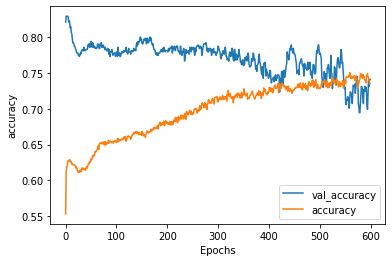

In [128]:
f = pyplot.figure()
pyplot.plot(history.history['val_accuracy'], label='val_accuracy')
pyplot.plot(history.history['accuracy'], label='accuracy')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.ylabel('accuracy')
pyplot.savefig('LSTM/lstm-1-acc.png')
pyplot.show()
now = datetime.datetime.now()

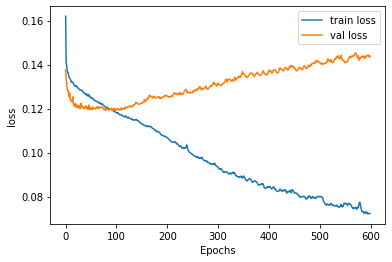

In [129]:
f1 = pyplot.figure()
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='val loss')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.ylabel('loss')
pyplot.savefig('LSTM/lstm-1-loss.png')
pyplot.show()
now = datetime.datetime.now()


In [130]:
end-start

173.29301238059998

In [131]:
np.shape(test_X)

(622, 1, 50)

In [132]:
# make a prediction
yhat = model.predict(test_X)

### Not compatible with Categorized pickups

(622, 8)


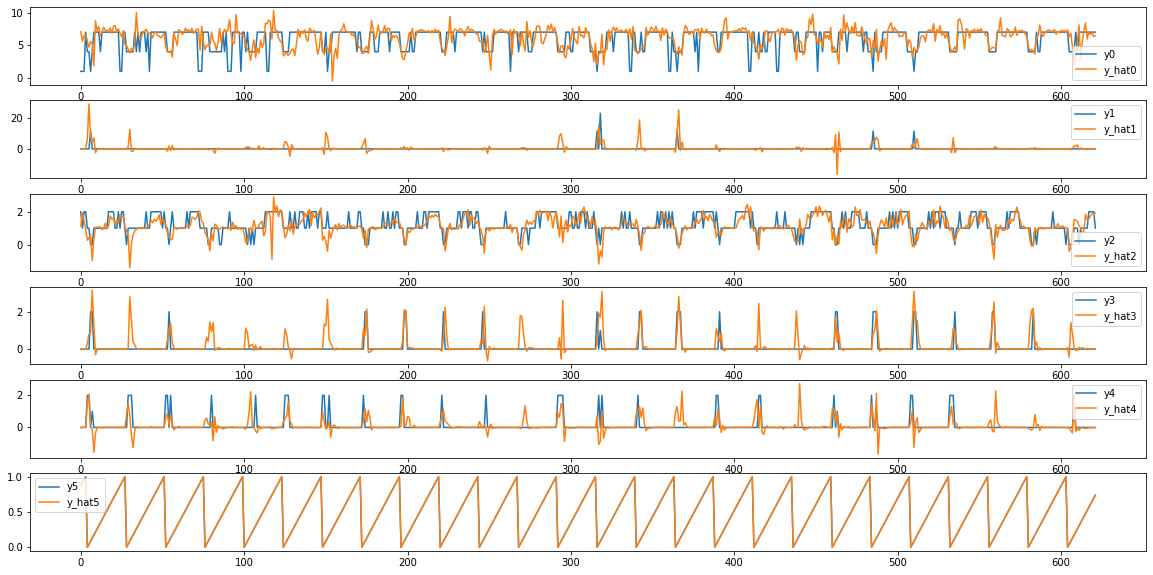

In [133]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 48:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), N))
inv_y = np.concatenate((test_y, test_X[:, 48:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:]
print(inv_y.shape)
f3 = pyplot.figure(figsize=(20,10))
pyplot.subplot(6, 1, 1)
pyplot.plot(inv_y[:,0],label='y0')
pyplot.plot(inv_yhat[:,0],label='y_hat0')
pyplot.legend()

pyplot.subplot(6, 1, 2)
pyplot.plot(inv_y[:,1],label='y1')
pyplot.plot(inv_yhat[:,1],label='y_hat1')
pyplot.legend()

pyplot.subplot(6, 1, 3)
pyplot.plot(inv_y[:,2],label='y2')
pyplot.plot(inv_yhat[:,2],label='y_hat2')
pyplot.legend()

pyplot.subplot(6, 1, 4)
pyplot.plot(inv_y[:,3],label='y3')
pyplot.plot(inv_yhat[:,3],label='y_hat3')
pyplot.legend()

pyplot.subplot(6, 1, 5)
pyplot.plot(inv_y[:,4],label='y4')
pyplot.plot(inv_yhat[:,4],label='y_hat4')
pyplot.legend()

pyplot.subplot(6, 1, 6)
pyplot.plot(inv_y[:,-1],label='y5')
pyplot.plot(inv_yhat[:,-1],label='y_hat5')
pyplot.legend()


pyplot.show()
now = datetime.datetime.now()

In [134]:
# calculate RMSE
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.252
